# **IMAGE CAPTION GENERATOR WITH VOICE INTEGERATION- A DEEP LEARNING APPROACH USING NEURAL NETWORK**



# **1.Importing Libraries**

In [1]:
# Install Libraries
!pip install torch
!pip install keras
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import InceptionV3
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm_notebook
from collections import Counter
import pickle
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Text to Voice Model

In [5]:
model, example_text = torch.hub.load(
    repo_or_dir='snakers4/silero-models',
    model='silero_tts',
    language='en',
    speaker='v3_en'
)

Downloading: "https://github.com/snakers4/silero-models/zipball/master" to /root/.cache/torch/hub/master.zip


100%|██████████| 54.5M/54.5M [00:03<00:00, 14.4MB/s]


# **2. Data assigning and Pre-processing**

## **2.1 Uploading**

In [7]:
# Path to the images
IMAGES_PATH = "/content/drive/MyDrive/flickr30k_images/flickr30k_images/"
# Path to the captions
CAPTIONS_PATH = "/content/drive/MyDrive/flickr30k_images/ICG.csv"
# Count images
num_images = len(os.listdir(IMAGES_PATH))
print(f"Number of images: {num_images}")

# Count captions
captions_df = pd.read_csv(CAPTIONS_PATH)
print(f"Number of captions: {len(captions_df)}")

#See first few captions
print(captions_df.head())


Number of images: 31809
Number of captions: 158915
   Unnamed: 0          Images  \
0           0  1000092795.jpg   
1           1  1000092795.jpg   
2           2  1000092795.jpg   
3           3  1000092795.jpg   
4           4  1000092795.jpg   

                                                Text  
0   Two young guys with shaggy hair look at their...  
1   Two young  White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


## **2.2Model Hyper Paramerters**

In [8]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Fixed length allowed for any sequence
SEQ_LENGTH = 24

# Vocabulary size
VOCAB_SIZE = 13000

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Batch size
BATCH_SIZE = 64

# Number of epochs
EPOCHS = 30

## **2.3 Checking invalid or missing file and Standarization**




In [9]:

def load_captions_data(filename):
    caption_mapping = {}
    text_data = []
    images_to_skip = set()
    countskip=0
    countcaptionskip=0
    try:
        with open(filename, "r", encoding="utf-8") as caption_file:
            lines = caption_file.readlines()[1:]  # Skip header

            for line in lines:
                line = line.strip()
                if not line:
                    continue

                try:
                    # splitting extra field
                    parts = line.split(",")
                    if len(parts) == 3:
                        _,img_name, caption = parts
                    elif len(parts) == 2:
                        img_name, caption = parts
                        caption = caption[4:]  # Removing extra label
                    else:
                        countcaptionskip+=1 #Add if any captions are improper
                        continue  # Skip badly formatted lines
                except Exception as e:
                    print(f"Skipping line due to parsing error: {line}")
                    continue

                img_name = os.path.join(IMAGES_PATH, img_name.strip())
                tokens = caption.strip().split()

                if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                    images_to_skip.add(img_name)
                    continue

                if img_name.endswith(".jpg") and img_name not in images_to_skip:
                    caption = "<start> " + caption.strip() + " <end>"
                    text_data.append(caption)

                    if img_name in caption_mapping:
                        caption_mapping[img_name].append(caption)
                    else:
                        caption_mapping[img_name] = [caption]

        # Remove any image entries that were flagged to skip
        for img_name in images_to_skip:
            countskip+=1 #Add if any images are needed to skip
            caption_mapping.pop(img_name, None)

    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error while loading captions: {str(e)}")

    return caption_mapping, text_data,countskip, countcaptionskip


# Loading the dataset
captions_mapping, text_data, countskip, countcaptionskip = load_captions_data(CAPTIONS_PATH)

print(f"Data Skipped Due to Wrongly formatted Images:{countskip}")
print(f"Total number of Data Skipped: {countskip + countcaptionskip}")
print(f"Total number of samples: {len(captions_mapping)}")



Data Skipped Due to Wrongly formatted Images:4986
Total number of Data Skipped: 4986
Total number of samples: 26797


## **2.4 Splitting Dataset**

In [10]:
# Splits the dataset into training, validation, and test sets
def train_val_split(caption_data, validation_size=0.2, test_size=0.02, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle
    if shuffle:
        np.random.shuffle(all_images)

    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)

    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}

    # Return the splits
    return training_data, validation_data, test_data
    # Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

----> Number of training samples: 21437
----> Number of validation samples: 5252
----> Number of test samples: 108


## **2.5 Vectorization**

In [11]:
# Custom standardization function
def custom_standardization(input_string):
    # Lowercasing all captions
    lowercase = tf.strings.lower(input_string)
    # Characters to remove
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer
vectorization = TextVectorization(
    # Number of unique tokens
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    # Maximum length of captions (padding for shorter ones)
    output_sequence_length=SEQ_LENGTH,
    # Apply custom standardization
    standardize=custom_standardization
)

# Adapting the vectorizer with the captions
vectorization.adapt(text_data)
#Image Augmentation
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.2),
                                       layers.RandomContrast(0.3)])
# Standardizing the text data
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))



## **2.2Visualize data**

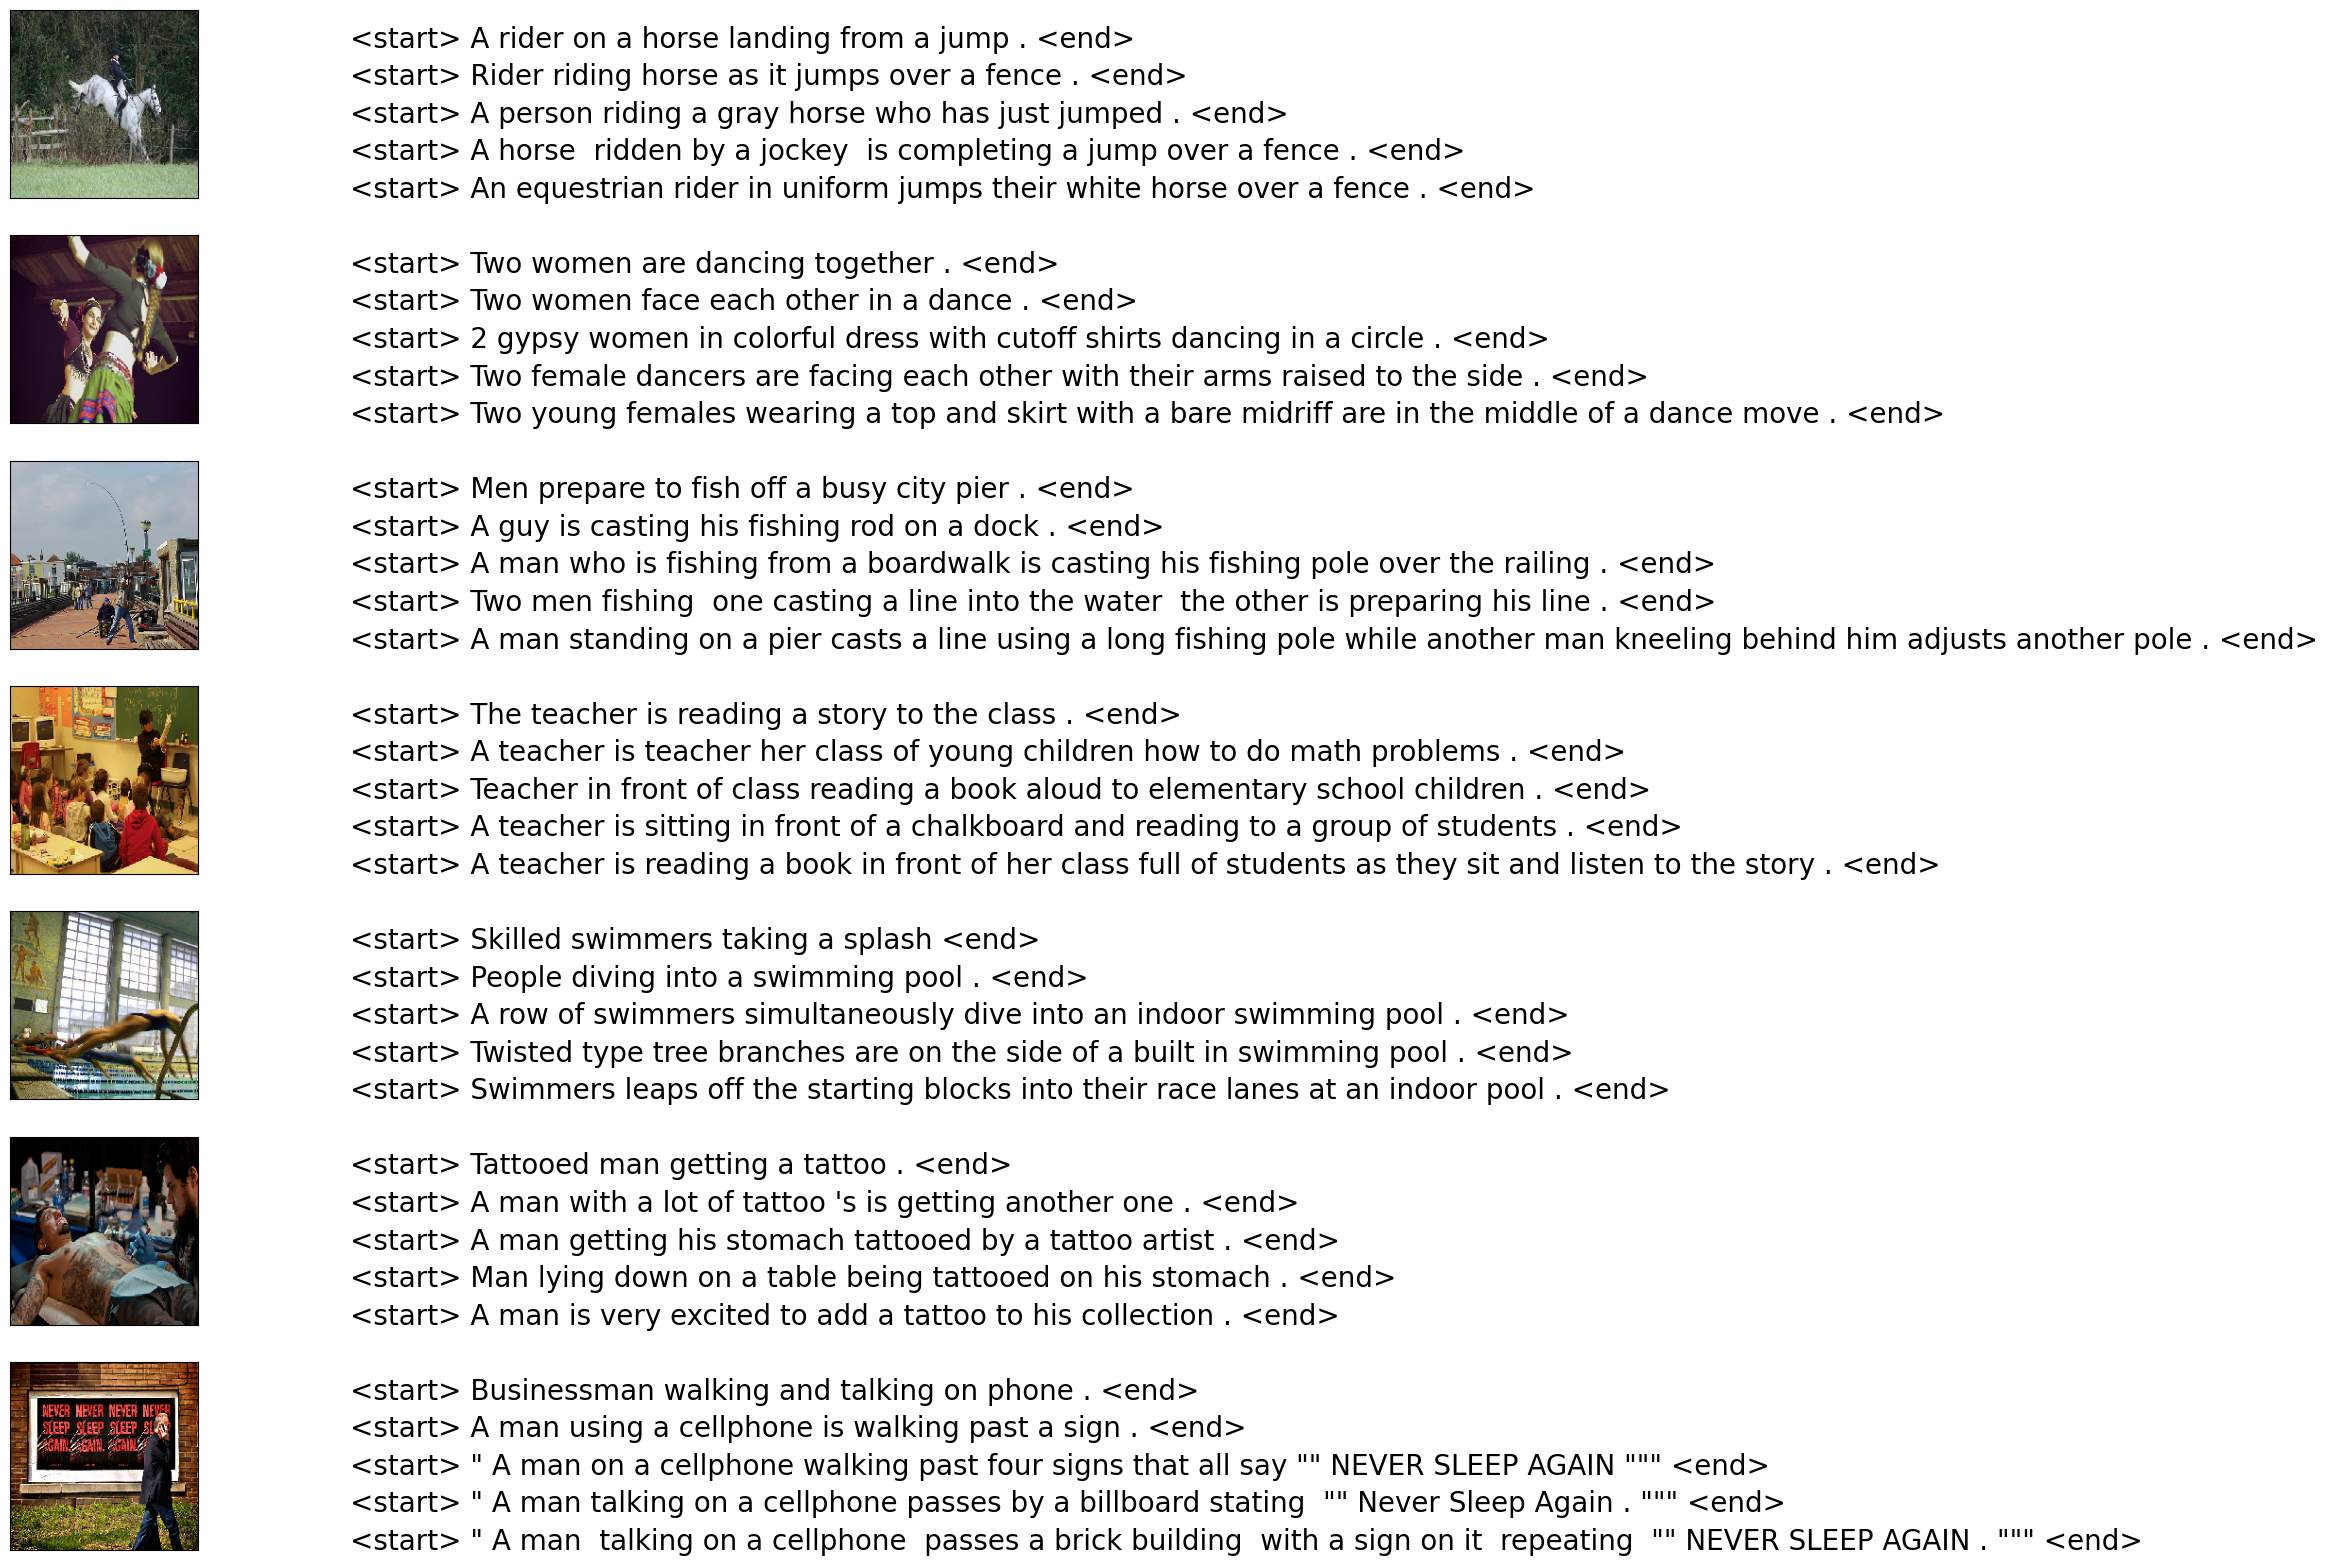

In [12]:
def visualaization(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[100:100+num_of_images]:
        captions = data[filename]
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(train_data, 7)

### **Histogram for caption length**

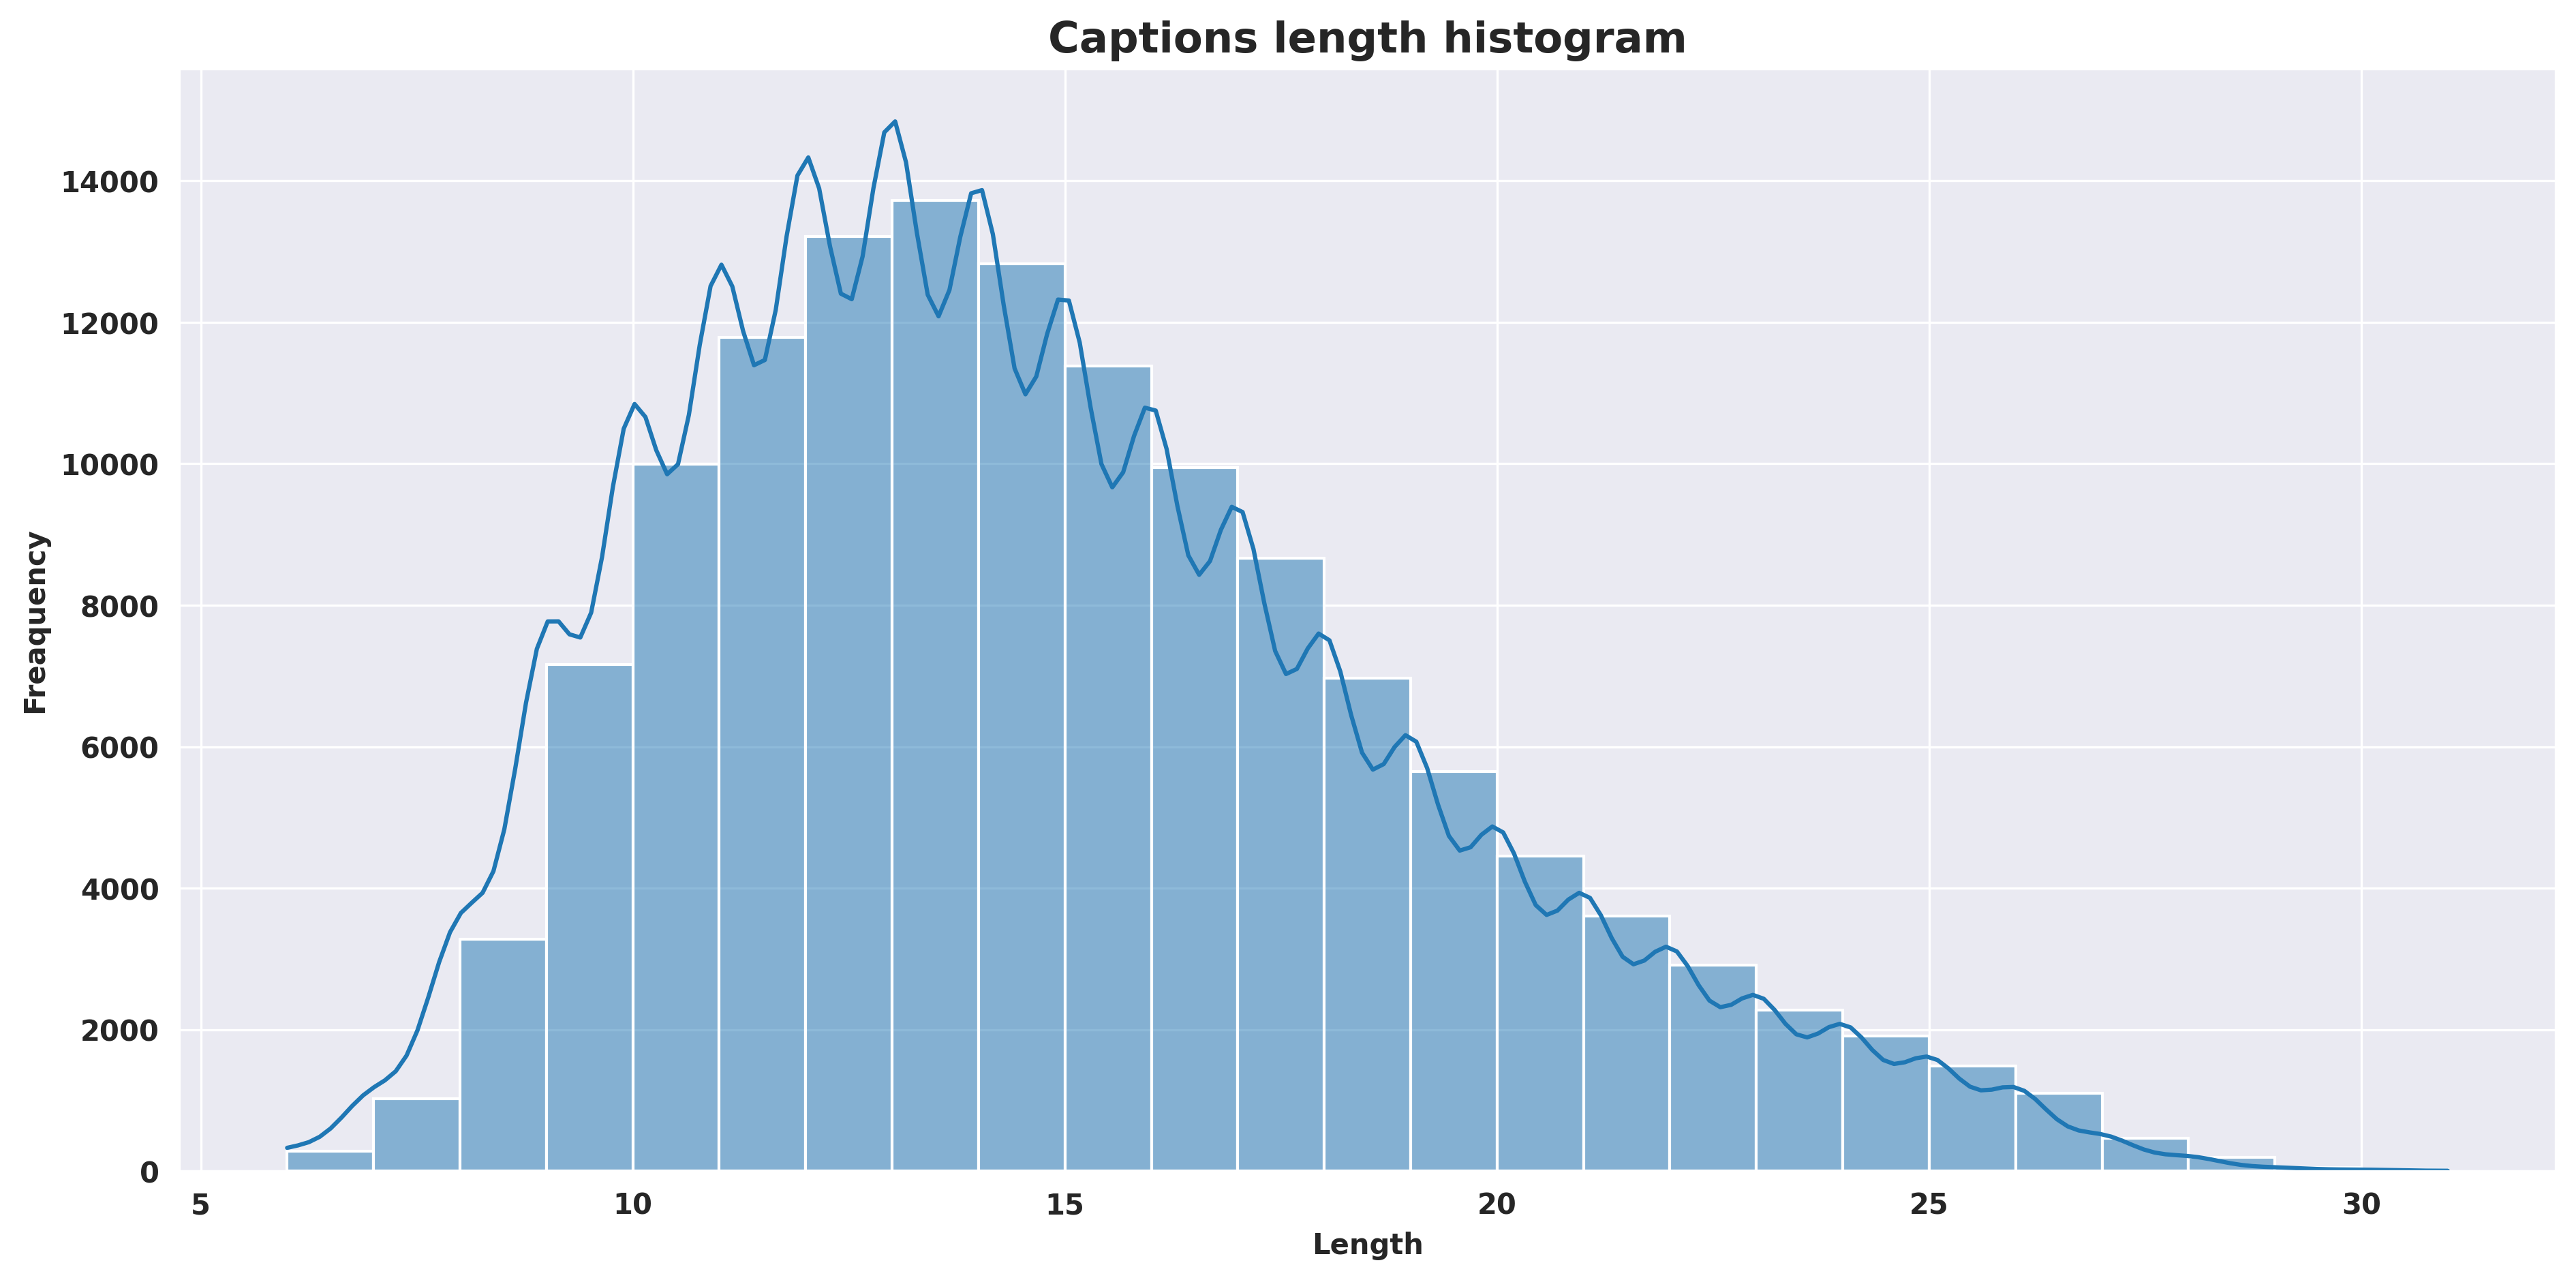

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(text_data)

# **3. Feature Extraction**

## **3.1 Image Processing and dataset preparation**




In [13]:
# Processes the images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def process_input(img_path, captions):
    # Processed images: (None, 299, 299, 3), Vectorized captions: (None, None, 25)
    return decode_and_resize(img_path), vectorization(captions)

# Prepares the dataset
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetching the next batch of data based on available resources while the current batch is being processed.
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset


# Making the datasets by passing the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))


## **3.2 Feature Extracting**

In [14]:
def get_cnn_model():
    # Load InceptionV3 with imagenet weights, exclude top layer
    base_model = keras.applications.InceptionV3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )

    # Freeze weights of base model
    base_model.trainable = False

    # Get the output of the last conv layer
    base_model_out = base_model.output  # shape: (None, 8, 8, 2048)

    # Reshape to match transformer input: (batch, num_patches, channels)
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

    # Create the CNN model
    cnn_model = keras.models.Model(inputs=base_model.input, outputs=base_model_out)
    return cnn_model



#**3. Model**

## **3.1 Encoder**

In [15]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
       ## self.dropout = layers.Dropout(0.3) # Define dropout layer

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
       ## inputs = self.dropout(inputs, training=training)
        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=None,
                                              training=training)
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

## **3.2 Decoder**

In [16]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # Positional encoding
        embedded_tokens = self.token_embeddings(inputs) # Input embedding
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # Positional embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


@tf.keras.utils.register_keras_serializable()
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)

        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)

        self.supports_masking = True
    def call(self, inputs, encoder_outputs, training=False, mask=None):
      # inputs shape: [B, L] where L is SEQ_LENGTH-1
      x = self.embedding(inputs)  # [B, L, D]
      # build masks for length L
      if mask is None:
        dec_pad = tf.math.not_equal(inputs, 0)  # [B, L]
      else:
        dec_pad = tf.cast(mask, tf.bool)
      causal = self.get_causal_attention_mask(x)          # [B, L, L]
      dec_pad_exp = tf.expand_dims(dec_pad, axis=1)       # [B, 1, L]
      combined = tf.math.logical_and(causal, dec_pad_exp)      # [B, L, L]
      # --- Self attention ---
      attn1 = self.attention_1(
        query=x, value=x, key=x,
        attention_mask=combined, # Use the combined mask
        training=training
        )
      out1 = self.layernorm_1(x + attn1)
      # --- Cross attention ---
      cross_mask = tf.expand_dims(dec_pad, axis=2)  # [B, L, 1]
      attn2 = self.cross_attention_2(
        query=out1,
        value=encoder_outputs,
        key=encoder_outputs,
        attention_mask=cross_mask, # Use the cross mask
        training=training
        )
      out2 = self.layernorm_2(out1 + attn2)
      # --- FFN ---
      ffn = self.ffn_layer_1(out2)
      ffn = self.dropout_1(ffn, training=training)
      ffn = self.ffn_layer_2(ffn)
      ffn = self.layernorm_3(out2 + ffn)
      ffn = self.dropout_2(ffn, training=training)

      return self.out(ffn)   # [B, L, vocab]


    def get_causal_attention_mask(self, x):
   
        shape = tf.shape(x)
        B = shape[0]
        L = shape[1]
        i = tf.range(L)[:, None]
        j = tf.range(L)[None, :]
        # True for j <= i (past + current), False for future
        mask = tf.math.greater_equal(i, j)              # [L, L] bool
        mask = tf.expand_dims(mask, axis=0)             # [1, L, L]
        mask = tf.tile(mask, [B, 1, 1])                 # [B, L, L]
        return mask

## **3.3 Image Captioning Model Architecture**

In [17]:
@tf.keras.utils.register_keras_serializable()
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,  **kwargs):
        super().__init__(**kwargs)
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        print()
        print(f'CNN input shape: {cnn_model.input_shape}')
        print(f'CNN output shape: {cnn_model.output_shape}', end='\n'*2)
        print(f'Encoder input ---> Dense layer shape: {cnn_model.output_shape} ---> (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})', end='\n'*2)
        print(f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH-1}) ---> (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH-1}, {VOCAB_SIZE})')


    # Calculates the loss, taking into account a mask to handle padding.
    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    # Calculates the accuracy, taking into account a mask to handle padding.
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        # Creating a binary mask where 1 indicates a valid token, and 0 indicates padding.
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    # Iterates through each caption for the given image, computes loss and accuracy, updates weights, and trackers.
    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Applies image augmentation if image_aug is provided.
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i], training=True)

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    # Similar to train_step but without updating weights.
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i], training=False)

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We must list the metrics here so the `reset_states()` can be,
                                                  # called automatically.
        return [self.loss_tracker, self.acc_tracker]

    def call(self, inputs, training=False):
      if isinstance(inputs, dict):
        batch_img = inputs["img"]
        batch_seq = inputs["seq"]
      else:
        batch_img, batch_seq = inputs
      img_embed = self.cnn_model(batch_img, training=training)
      encoder_out = self.encoder(img_embed, training=training)
      output = self.decoder(batch_seq, encoder_out, training=training)
      return output

    def get_config(self):
      config = super().get_config()
      config.update({
        "cnn_model": serialize_keras_object(self.cnn_model),
        "encoder": serialize_keras_object(self.encoder),
        "decoder": serialize_keras_object(self.decoder),
        "num_captions_per_image": self.num_captions_per_image,
        "image_aug": serialize_keras_object(self.image_aug) if self.image_aug else None,
        })
      return config

    @classmethod
    def from_config(cls, config):
      cnn_model = deserialize_keras_object(config.pop("cnn_model"))
      encoder = deserialize_keras_object(config.pop("encoder"))
      decoder = deserialize_keras_object(config.pop("decoder"))
      return cls(cnn_model=cnn_model, encoder=encoder, decoder=decoder, **config)


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

CNN input shape: (None, 299, 299, 3)
CNN output shape: (None, 64, 2048)

Encoder input ---> Dense layer shape: (None, 64, 2048) ---> (None, 64, 512)
Encoder output shape: (None, 64, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 23) ---> (None, 23, 512)
Decoder input 2 (Embedded image features) shape: (None, 64, 512)
Decoder output (MH Cross-Attention) shape: (None, 23, 512)
Decoder prediction (Dense layer) shape: (None, 23, 13000)


## **3.5Compiling and Training the Model**

In [18]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation lfoross  8 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

# Learning Rate Scheduler for the optimizer
@tf.keras.utils.register_keras_serializable()
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)

    def get_config(self):
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }


# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 988s 3s/step - acc: 0.1837 - loss: 31.8659 - val_acc: 0.3405 - val_loss: 18.9132
Epoch 2/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 192s 573ms/step - acc: 0.3365 - loss: 18.7994 - val_acc: 0.3652 - val_loss: 17.2050
Epoch 3/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 194s 580ms/step - acc: 0.3586 - loss: 17.2591 - val_acc: 0.3797 - val_loss: 16.3993
Epoch 4/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 581ms/step - acc: 0.3716 - loss: 16.4262 - val_acc: 0.3878 - val_loss: 15.9922
Epoch 5/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 582ms/step - acc: 0.3807 - loss: 15.8470 - val_acc: 0.3925 - val_loss: 15.7236
Epoch 6/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 582ms/step - acc: 0.3875 - loss: 15.4215 - val_acc: 0.3968 - val_loss: 15.5396
Epoch 7/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 582ms/step - acc: 0.3942 - loss: 15.0650 - val_acc: 0.3980 - val_loss: 15.4604
Epoch 8/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 582ms/step - acc: 0.4001 - loss: 14.7425 - val_acc: 0.4002 - val_loss: 15.3543
Epoch 9/30


## **3.6 Visualizing Training Results**

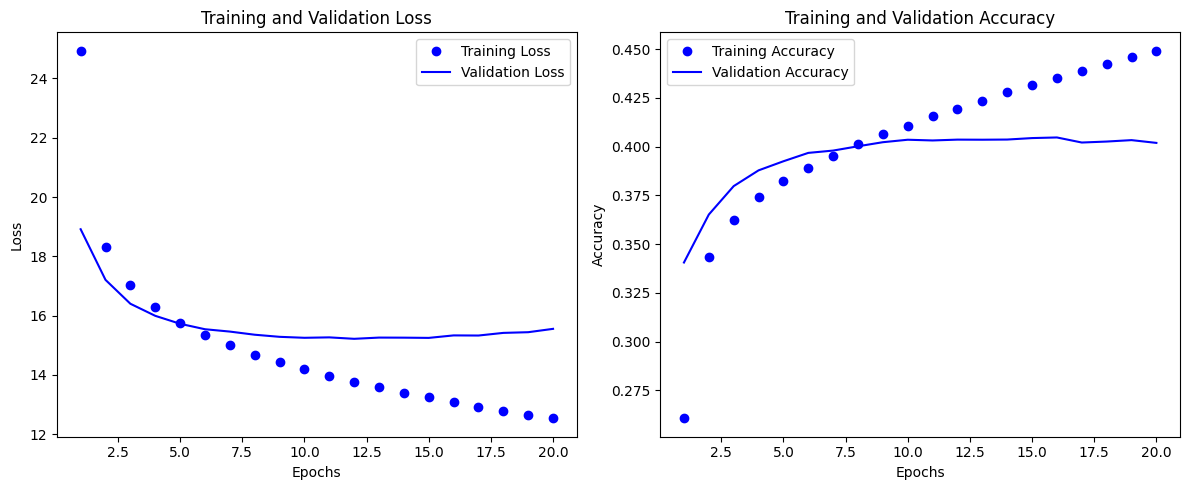

In [19]:
# Visualize training results

import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') # Often needed with wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

##  **3.7 Generating Captions using Test Data**

In [22]:
import os
from IPython.display import Audio, display
from tensorflow.keras.utils import serialize_keras_object, deserialize_keras_object

vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1
test_images = list(test_data.keys())

with open("vocab.txt", "w", encoding="utf-8") as f:
    for token in vocab:
        f.write(token + "\n")

def greedy_algorithm(image):
    # Read the image from the disk
    image = decode_and_resize(image)
    # Pass the image to the CNN
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(image, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
  cap = greedy_algorithm(image_id)
  generated_captions[image_id] = cap
  pbar.update(1)


pbar.close()
for image_id in generated_captions:
    actual_captions = test_data[image_id]  # ground truth captions
    predicted_caption = generated_captions[image_id]

    print(f"\nImage: {image_id}")
    print("Predicted Caption:", predicted_caption)

    print('Audio is being generated...')
    model.save_wav(text=predicted_caption,
               speaker='en_0',
               sample_rate=48000, audio_path=f'{image_id}.wav')
    # Ask the user if they want to play the audio
    choice = input("Play the audio (yes/no)? ").strip().lower()
    if choice == "yes":
      # Play audio inside Colab
      display(Audio(f'{image_id}.wav', autoplay=True))
      print("Audio playback finished.")

      # Delete the file after playback
      if os.path.exists(f'{image_id}.wav'):
        os.remove(f'{image_id}.wav')
        print(f"Deleted file: {f'{image_id}.wav'}")
    else:
      print("Audio not played.")
      os.remove(f'{image_id}.wav')

  0%|          | 0/108 [00:00<?, ?it/s]


Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/271043166.jpg
Predicted Caption: a group of people are sitting at a table
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/271043166.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/73450556.jpg
Predicted Caption: a group of people are gathered around a table
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/73450556.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/519167484.jpg
Predicted Caption: a girl in a pink dress is hula hooping
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/519167484.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/2208310655.jpg
Predicted Caption: a young girl in a pink shirt is holding a baby
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/2208310655.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/3308612894.jpg
Predicted Caption: a baby in a highchair is being held by a man
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/3308612894.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/3487533923.jpg
Predicted Caption: a woman in a pink shirt is riding a bike
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/3487533923.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/494921598.jpg
Predicted Caption: a hockey player is trying to score a goal
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/494921598.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/2845080955.jpg
Predicted Caption: a woman in a pink coat is standing in front of a blue wall
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/2845080955.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/1413956047.jpg
Predicted Caption: a man in a white shirt and blue jeans is standing on a rock
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/1413956047.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/489865145.jpg
Predicted Caption: a young boy in a blue shirt is standing on a sidewalk
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/489865145.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/5615077255.jpg
Predicted Caption: a group of children are playing in a game
Audio is being generated...
Play the audio (yes/no)? 
Audio not played.

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/4940539020.jpg
Predicted Caption: a man in a blue shirt is walking down the sidewalk
Audio is being generated...
Play the audio (yes/no)? s
Audio not played.

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/329832949.jpg
Predicted Caption: a young boy in a red shirt is holding a large piece of paper
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/329832949.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/4935054795.jpg
Predicted Caption: a man in a blue shirt is walking down a street
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/4935054795.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/4770473055.jpg
Predicted Caption: a man in a black shirt is holding a red flag
Audio is being generated...
Play the audio (yes/no)? yes


Audio playback finished.
Deleted file: /content/drive/MyDrive/flickr30k_images/flickr30k_images/4770473055.jpg.wav

Image: /content/drive/MyDrive/flickr30k_images/flickr30k_images/2497747805.jpg
Predicted Caption: a man in a blue shirt is playing beach volleyball on the beach
Audio is being generated...


KeyboardInterrupt: Interrupted by user

## **3.8 Saving the Model**

In [23]:
# Run dummy pass to build model
try:
    dummy_img = tf.random.uniform(shape=(1, 299, 299, 3))
    dummy_seq = tf.random.uniform(shape=(1, 24), maxval=13000, dtype=tf.int32)
    _ = caption_model((dummy_img, dummy_seq), training=False)
except:
    print('model not tested')

# Save full model
caption_model.save("caption_model.keras")

from google.colab import files
files.download("caption_model.keras")
files.download("vocab.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Evaluation**

## **4.1 Evaluation using BLEU scores**

In [24]:
# Calculates BLEU score of predictions
def BLEU_score(actual, predicted):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)

    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1=corpus_bleu(processed_actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(processed_actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(processed_actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(processed_actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}')
    ]

In [25]:
def BLEU_score(actual, predicted):
    # Process actual captions (tokenize each reference caption)
    processed_actual = []
    for caps in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(caps).numpy() if INDEX_TO_WORD[x] != '']
        tokens = cap  # if already a list of words
        processed_actual.append([tokens])  # wrapped in list for corpus_bleu

    # Process predicted captions (tokenize)
    processed_pred = []
    for cap in predicted:
        processed_pred.append(cap.split())  # or word_tokenize(cap)

    # BLEU scores
    b1 = corpus_bleu(processed_actual, processed_pred, weights=(1.0, 0, 0, 0))
    b2 = corpus_bleu(processed_actual, processed_pred, weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu(processed_actual, processed_pred, weights=(0.33, 0.33, 0.33, 0))
    b4 = corpus_bleu(processed_actual, processed_pred, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        f'BLEU-4: {round(b4, 5)}',
        f'BLEU-3: {round(b3, 5)}',
        f'BLEU-2: {round(b2, 5)}',
        f'BLEU-1: {round(b1, 5)}',
        f'Generated Caption: {" ".join(predicted[0]) if isinstance(predicted[0], list) else predicted[0]}'
    ]


## **4.2 Visualizing test data with BLEU scores**

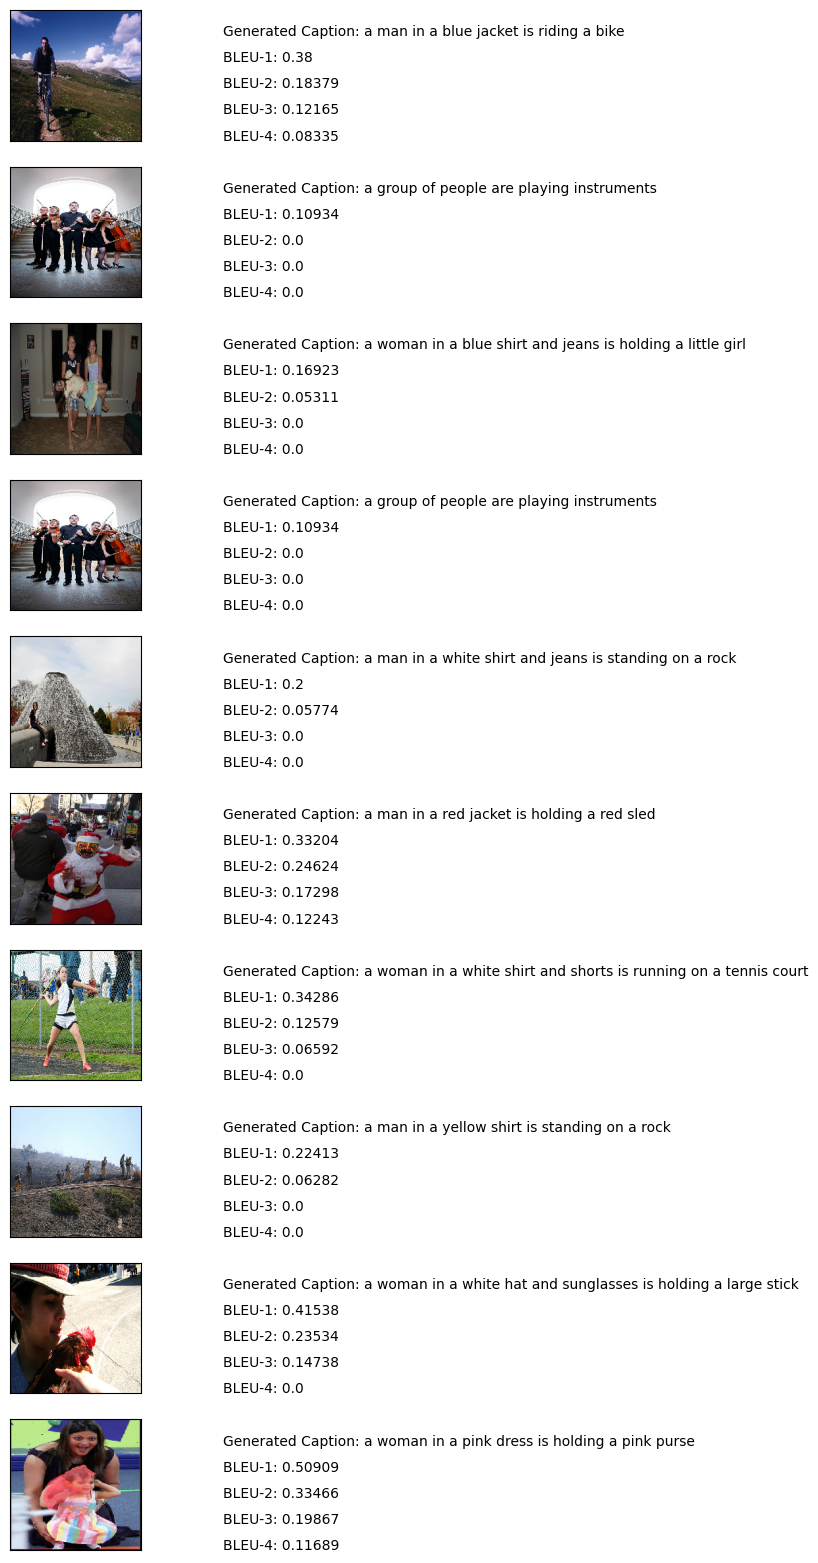

In [26]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("<start> ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" <end>", "") for x in actual_cap] # Removing the end token

        caption = generated_captions[filename]
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [caption]*(len(actual_cap)))

        image_load = load_img(filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_data, generated_captions, BLEU_score, 10)

## **4.3 Visualization of Average of BLEU Scores Accross All Test Images**


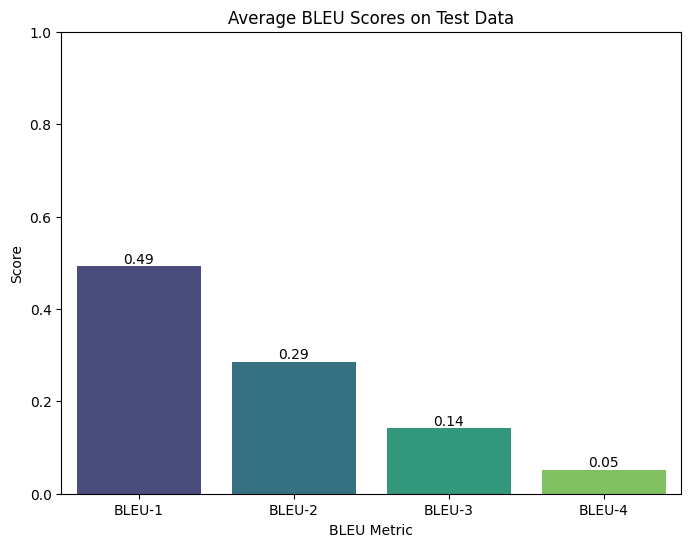

In [27]:
# Calculate average BLEU scores across all test images
bleu_1_scores = []
bleu_2_scores = []
bleu_3_scores = []
bleu_4_scores = []

for image_id, predicted_caption in generated_captions.items():
    actual_captions = test_data[image_id]
    processed_actual = []
    for cap in actual_captions:
        cap = cap.replace("<start> ", "").replace(" <end>", "").strip()
        processed_actual.append(cap.split())

    processed_pred = predicted_caption.split()

    # Calculate individual BLEU scores for this image
    b1 = corpus_bleu([processed_actual], [processed_pred], weights=(1.0, 0, 0, 0))
    b2 = corpus_bleu([processed_actual], [processed_pred], weights=(0.5, 0.5, 0, 0))
    b3 = corpus_bleu([processed_actual], [processed_pred], weights=(0.33, 0.33, 0.33, 0))
    b4 = corpus_bleu([processed_actual], [processed_pred], weights=(0.25, 0.25, 0.25, 0.25))

    bleu_1_scores.append(b1)
    bleu_2_scores.append(b2)
    bleu_3_scores.append(b3)
    bleu_4_scores.append(b4)

# Calculate average BLEU scores
avg_bleu_1 = np.mean(bleu_1_scores)
avg_bleu_2 = np.mean(bleu_2_scores)
avg_bleu_3 = np.mean(bleu_3_scores)
avg_bleu_4 = np.mean(bleu_4_scores)

# Create a DataFrame for plotting
bleu_scores_df = pd.DataFrame({
    'BLEU Score': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'Score': [avg_bleu_1, avg_bleu_2, avg_bleu_3, avg_bleu_4]
})

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='BLEU Score', y='Score', data=bleu_scores_df, palette='viridis')
plt.title('Average BLEU Scores on Test Data')
plt.ylim(0, 1) # BLEU scores are between 0 and 1
plt.ylabel('Score')
plt.xlabel('BLEU Metric')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## **4.3 Evaluation using METEOR Metrics**





In [28]:
# Prepare captions for evaluation
references_list = []
predictions_list = []

for image_id, predicted_caption in generated_captions.items():
    # Get the actual captions for the current image
    actual_captions = test_data[image_id]

    # Process actual captions: remove start/end tokens and tokenize each
    # Keep references as a list of lists of tokens for METEOR
    processed_actual_captions_tokens = []
    for cap in actual_captions:
        cap = cap.replace("<start> ", "").replace(" <end>", "").strip()
        processed_actual_captions_tokens.append(cap.split()) # Tokenize
    references_list.append(processed_actual_captions_tokens)

    # Process predicted caption: tokenize for METEOR
    predictions_list.append(predicted_caption.split())

# --- METEOR ---
# meteor_score expects references as a list of list of tokenized strings
# and hypothesis as a single tokenized string.
meteor_scores = [meteor_score(refs, pred) for refs, pred in zip(references_list, predictions_list)]
print(f"METEOR: {np.mean(meteor_scores):.4f}")

METEOR: 0.3215


In [30]:


# Assuming you have already calculated meteor_scores, rouge_scores, cider_score, and spice_score
# (These variables should be available from the previous execution)

# Calculate the mean scores
mean_meteor_score = np.mean(meteor_scores)
# Create a pandas DataFrame to display the scores
evaluation_scores = {
    "Metric": ["METEOR"],
    "Score": [mean_meteor_score]
}

evaluation_df = pd.DataFrame(evaluation_scores)

# Display the DataFrame
display(evaluation_df)

Metric     Score
0  METEOR  0.321488